In [94]:
import numpy as np
import pandas as pd
import json
import random
import math
from time import time
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt

import folium

# TSP Analysis for Orange County Deliveries


## Setup and Data Loading

In [95]:
# Load Files
distance_matrix = np.load('distance_matrix.npy')
print(f"Distance matrix shape: {distance_matrix.shape}")

with open('locations_mapping.json', 'r') as f:
    locations_mapping = json.load(f)

print(f"Number of locations: {len(locations_mapping)}")
print("\nExample distance:", distance_matrix[0][1])
print("\nExample location data:", locations_mapping['0'])



Distance matrix shape: (201, 201)
Number of locations: 201

Example distance: 26649.0

Example location data: {'latitude': 33.6424, 'longitude': -117.8417, 'address': 'UCI Warehouse: 2006 McGaw Ave, Irvine, CA 92614'}


In [ ]:
def calculate_route_distance(route, distance_matrix):
    """Calculate total distance of a route including return to warehouse"""
    total_distance = 0
    for i in range(len(route) - 1):
        total_distance += distance_matrix[route[i]][route[i + 1]]
    # Add distance back to warehouse (index 0)
    total_distance += distance_matrix[route[-1]][0]
    return total_distance

def plot_route(route, locations_mapping, distance_matrix, title="TSP Route"):
    """Plot the route on a scatter plot"""
    plt.figure(figsize=(12, 8))
    
    # Extract coordinates using longitude and latitude
    x_coords = [locations_mapping[str(i)]['longitude'] for i in route]
    y_coords = [locations_mapping[str(i)]['latitude'] for i in route]
    
    # Add warehouse return coordinates
    x_coords.append(locations_mapping['0']['longitude'])
    y_coords.append(locations_mapping['0']['latitude'])
    
    # Plot points and routes
    plt.scatter(x_coords, y_coords, c='blue', s=50)
    plt.plot(x_coords, y_coords, 'r-', alpha=0.5)
    
    # Highlight warehouse
    plt.scatter([x_coords[0]], [y_coords[0]], c='red', s=100, label='Warehouse')
    
    # Add title and total distance
    total_distance = calculate_route_distance(route, distance_matrix)
    plt.title(f"{title}\nTotal Distance: {total_distance:.2f}")
    
    plt.legend()
    plt.grid(True)
    plt.show()

def plotted_map(best_route):
  locations_mapping_df = pd.DataFrame.from_dict(locations_mapping, orient='index').reset_index(drop=True)
  warehouse_start_point = [33.642400,-117.8417]
  map=folium.Map(location=warehouse_start_point, zoom_start=10.49,tiles="Cartodb Positron")
  folium.Marker(warehouse_start_point, popup="UCI Warehouse, 2006 McGaw Ave, Irvine, CA 92614", icon=folium.Icon(color="blue", icon="star")).add_to(map)

  locations_mapping_df_reset = locations_mapping_df.reset_index(drop=True)
  locations_mapping_df_reordered = locations_mapping_df_reset.loc[best_route].reset_index(drop=True)

  
  for i in range(len(locations_mapping_df_reordered) - 1):
    long1, lat1 = locations_mapping_df_reordered.loc[i,'longitude'], locations_mapping_df_reordered.loc[i,'latitude']
    long2, lat2 = locations_mapping_df_reordered.loc[i+1,'longitude'], locations_mapping_df_reordered.loc[i+1,'latitude']

    folium.CircleMarker([lat1, long1], radius=3, fill=False, fill_opacity=.1 ,color='blue', popup=i).add_to(map)
    folium.PolyLine([[lat1, long1],[lat2,long2]], color = "red").add_to(map)

  return map

# Geo Distance matrix (euclidean distance)

---

Test route: [0, 3, 4, 1, 2]
Test route distance: 122233.0


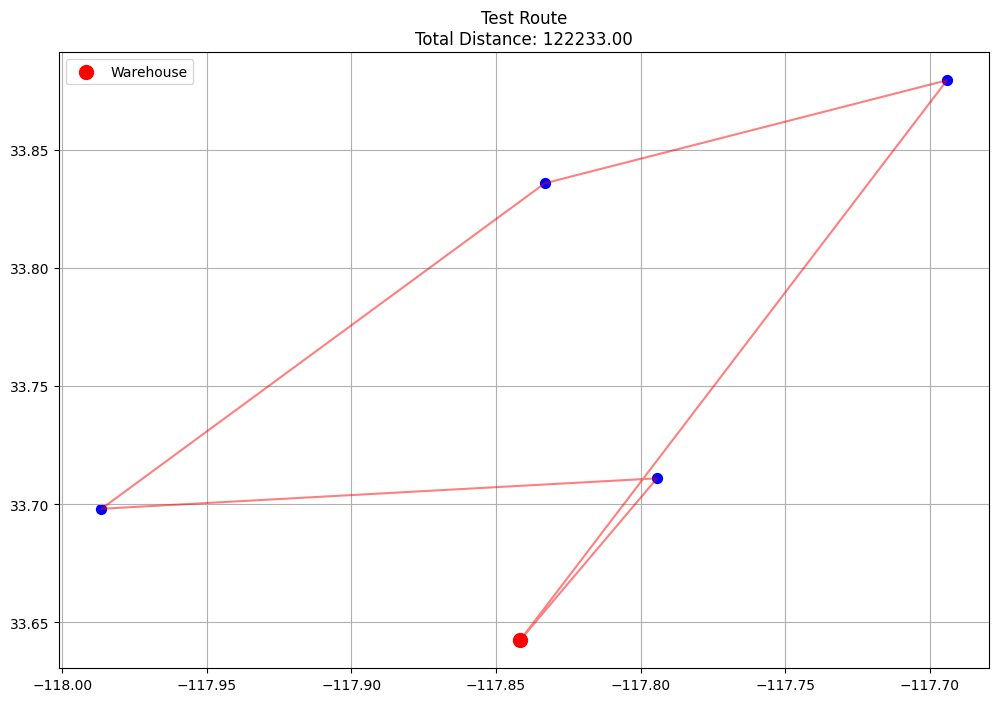

In [98]:
# Test the functions
test_route = [0] + random.sample(range(1, 5), 4)  # Small 5-location route
print("Test route:", test_route)
print("Test route distance:", calculate_route_distance(test_route, distance_matrix))
plot_route(test_route, locations_mapping, distance_matrix, "Test Route")

# Implement Algorithms

---

## Nearest Neighbor

In [99]:
def nearest_neighbor(address_dict):
    # Convert the dictionary to a DataFrame titled 'locations_mapping_df'
    locations_mapping_df = pd.DataFrame.from_dict(address_dict, orient='index').reset_index(drop=True)

    # Create 2 dataframes: remaining_node includes addresses without the starting point (UCI Warehouse); visited_address will append order of address visited starting from UCI Warehouse
    remaining_node = locations_mapping_df.iloc[1:].reset_index(drop=True)  # Exclude the first row
    visited_address = locations_mapping_df.iloc[:1].reset_index(drop=True)  # Include only the first row

    while not remaining_node.empty: 
        # Get the coordinates of the last visited location
        current_longitude_coordinate = visited_address.iloc[-1]['longitude']
        current_latitude_coordinate = visited_address.iloc[-1]['latitude']

        # Calculate distances to all remaining nodes
        remaining_node = remaining_node.assign(
            Distance=np.sqrt(
                (current_longitude_coordinate - remaining_node["longitude"]) ** 2 +
                (current_latitude_coordinate - remaining_node["latitude"]) ** 2
            )
        )

        # Find the next address (row with the minimum distance)
        next_address = remaining_node.loc[remaining_node["Distance"].idxmin()]

        # Append the next address to the visited_address dataframe
        visited_address = pd.concat(
            [visited_address, pd.DataFrame([next_address], columns=remaining_node.columns)],
            ignore_index=True
        )

        # Remove the visited node from remaining nodes
        remaining_node = remaining_node.drop(remaining_node["Distance"].idxmin()).reset_index(drop=True)

    # Return to the start location
    visited_address = pd.concat([visited_address, locations_mapping_df.iloc[:1]], ignore_index=True)
    visited_address['number'] = visited_address['address'].map(locations_mapping_df.reset_index().set_index('address')['index'])
    nn_route = visited_address.loc[:,'number']


    return np.array(nn_route)


Nearest Neighbor Results:
Time taken: 0.13 seconds
Route length: 201
Total distance: 952123.00


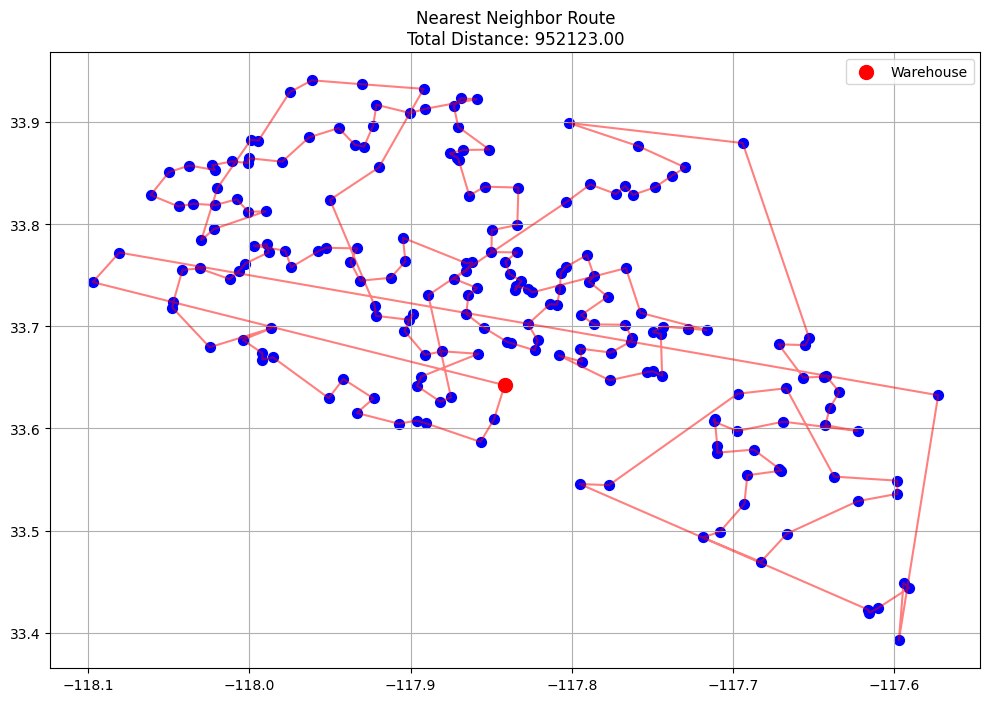

In [117]:
# Testing nearest neighbor

start_time = time()
nn_route = nearest_neighbor(locations_mapping)
nn_distance = calculate_route_distance(nn_route, distance_matrix)
end_time = time()

nn_time = end_time - start_time

print("\nNearest Neighbor Results:")
print(f"Time taken: {end_time - start_time:.2f} seconds")
print(f"Route length: {len(nn_route)-1}")
print(f"Total distance: {calculate_route_distance(nn_route, distance_matrix):.2f}")

plot_route(nn_route,locations_mapping, distance_matrix, "Nearest Neighbor Route")
plotted_map(nn_route)

## Simulated Annealing Search

In [101]:
def simulated_annealing(distance_matrix, initial_temp=100.0, cooling_rate=0.995, iterations=100000):
    """Implement Simulated Annealing algorithm"""
    start_time = time()
    n_cities = len(distance_matrix)
    
    # Generate initial solution
    current_route = [0] + random.sample(range(1, n_cities), n_cities-1)
    current_distance = calculate_route_distance(current_route, distance_matrix)
    
    best_route = current_route.copy()
    best_distance = current_distance
    
    temperature = initial_temp
    
    # Main loop
    for _ in range(iterations):
        # Generate neighbor by swapping two random cities (excluding warehouse)
        new_route = current_route.copy()
        idx1, idx2 = random.sample(range(1, len(new_route)), 2)
        new_route[idx1], new_route[idx2] = new_route[idx2], new_route[idx1]
        
        new_distance = calculate_route_distance(new_route, distance_matrix)
        
        # Accept if better, or with probability if worse
        if new_distance < current_distance:
            current_route = new_route
            current_distance = new_distance
            if new_distance < best_distance:
                best_route = new_route.copy()
                best_distance = new_distance
        else:
            if random.random() < np.exp(-(new_distance - current_distance) / temperature):
                current_route = new_route
                current_distance = new_distance
        
        temperature *= cooling_rate
    
    computation_time = time() - start_time
    return best_route, computation_time


Simulated Annealing Results:
Time taken: 4.84 seconds
Route length: 201
Total distance: 1602.26 km


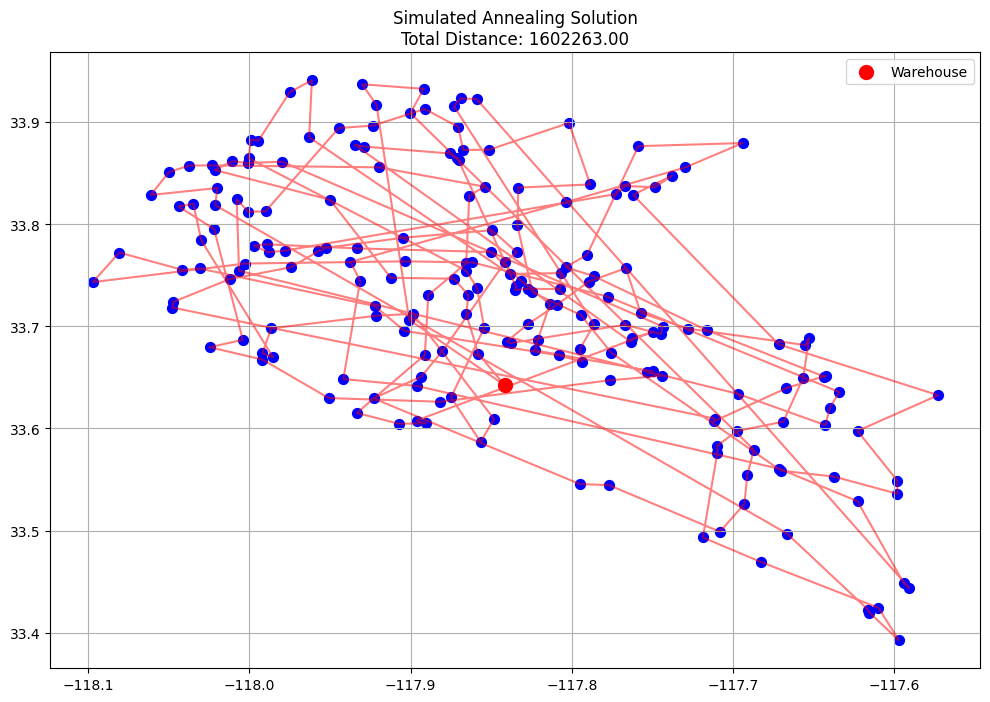

In [102]:
sa_route, sa_time = simulated_annealing(distance_matrix, 
                                       initial_temp=1000.0,  # Higher initial temperature
                                       cooling_rate=0.999,   # Slower cooling
                                       iterations=200000)    # More iterations

print("\nSimulated Annealing Results:")
print(f"Time taken: {sa_time:.2f} seconds")
print(f"Route length: {len(sa_route)}")
sa_distance = calculate_route_distance(sa_route, distance_matrix)
print(f"Total distance: {sa_distance/1000:.2f} km")

# Plot SA route
plot_route(sa_route, locations_mapping, distance_matrix, "Simulated Annealing Solution")
plotted_map(sa_route)

##  A* Search Algorithm

In [103]:
import heapq

def a_star_search(start, goal, travel_distance_matrix, geodesic_distance_matrix):
    """
    A* search to find the shortest path from start to goal.

    Parameters:
        start: Starting node index (e.g., warehouse is 0)
        goal: Goal node index (e.g., final destination)
        travel_distance_matrix: 2D matrix of travel distances (g function)
        geodesic_distance_matrix: 2D matrix of geodesic distances (h function)

    Returns:
        path: List of nodes representing the shortest path
        total_cost: Total travel distance of the path
    """
    n_nodes = len(travel_distance_matrix)
    
    # Priority queue: (f_score, current_node)
    priority_queue = []
    heapq.heappush(priority_queue, (0, start))
    
    # g_score: Cost from start to each node
    g_score = {i: float('inf') for i in range(n_nodes)}
    g_score[start] = 0
    
    # came_from: To reconstruct the path
    came_from = {}
    
    while priority_queue:
        # Get node with the smallest f_score
        current_f_score, current_node = heapq.heappop(priority_queue)
        
        # If goal is reached, reconstruct the path
        if current_node == goal:
            path = []
            while current_node in came_from:
                path.append(current_node)
                current_node = came_from[current_node]
            path.append(start)
            path.reverse()
            return path, g_score[goal]
        
        # Explore neighbors
        for neighbor in range(n_nodes):
            if neighbor == current_node:
                continue
            
            # Tentative g_score
            tentative_g_score = g_score[current_node] + travel_distance_matrix[current_node][neighbor]
            
            # If this path is better
            if tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current_node
                g_score[neighbor] = tentative_g_score
                
                # f_score = g_score + heuristic
                f_score = tentative_g_score + geodesic_distance_matrix[neighbor][goal]
                heapq.heappush(priority_queue, (f_score, neighbor))
    
    # If goal is not reachable
    return None, float('inf')


def tsp_a_star(travel_distance_matrix, geodesic_distance_matrix, start=0):
    """
    Solve the Traveling Salesman Problem using A*.

    Parameters:
        travel_distance_matrix: 2D matrix of travel distances
        geodesic_distance_matrix: 2D matrix of geodesic distances
        start: Starting node index (e.g., warehouse is 0)

    Returns:
        path: List of nodes representing the optimal route
        total_cost: Total travel distance of the route
    """
    n_nodes = len(travel_distance_matrix)
    visited = set()
    current_node = start
    path = [current_node]
    total_cost = 0
    
    while len(visited) < n_nodes - 1:  # Exclude return to warehouse
        visited.add(current_node)
        
        # Find the next node to visit
        best_next_node = None
        best_cost = float('inf')
        for neighbor in range(n_nodes):
            if neighbor in visited or neighbor == current_node:
                continue
            
            _, cost = a_star_search(current_node, neighbor, travel_distance_matrix, geodesic_distance_matrix)
            if cost < best_cost:
                best_next_node = neighbor
                best_cost = cost
        
        # Move to the next node
        if best_next_node is not None:
            path.append(best_next_node)
            total_cost += best_cost
            current_node = best_next_node
        else:
            break
    
    # Add the return to the warehouse
    path.append(start)
    total_cost += travel_distance_matrix[current_node][start]
    
    return path, total_cost

In [104]:
def load_cached_geodesic_distances():
    """Load the cached geodesic distance matrix and location mapping"""
    try:
        geodesic_distance_matrix = np.load('geodesic_distance_matrix.npy')
        with open('locations_mapping.json', 'r') as f:
            locations_mapping = json.load(f)
        return geodesic_distance_matrix, locations_mapping
    except:
        return None, None

Optimal Route: [0, 179, 183, 197, 46, 136, 17, 74, 62, 169, 177, 152, 49, 61, 123, 167, 70, 142, 66, 42, 143, 69, 95, 52, 178, 100, 6, 23, 35, 34, 13, 135, 68, 195, 191, 116, 3, 155, 102, 193, 21, 32, 140, 56, 176, 199, 73, 148, 181, 57, 67, 117, 108, 31, 72, 194, 58, 40, 36, 146, 162, 172, 10, 77, 7, 87, 51, 115, 126, 163, 157, 83, 161, 22, 76, 130, 198, 63, 128, 9, 175, 107, 132, 158, 50, 105, 82, 125, 180, 200, 168, 173, 121, 120, 124, 33, 45, 122, 160, 144, 186, 92, 54, 47, 165, 91, 43, 89, 39, 185, 196, 111, 170, 84, 71, 137, 99, 150, 41, 88, 147, 139, 1, 131, 5, 127, 118, 188, 97, 28, 60, 94, 65, 90, 114, 192, 75, 190, 98, 171, 30, 37, 4, 59, 27, 104, 166, 44, 64, 187, 81, 18, 101, 93, 20, 19, 174, 119, 133, 113, 141, 145, 129, 80, 38, 14, 159, 138, 110, 184, 96, 24, 151, 11, 153, 154, 16, 164, 12, 149, 26, 106, 112, 189, 29, 15, 86, 25, 8, 55, 53, 134, 48, 103, 109, 156, 182, 79, 85, 78, 2, 0]
Total Distance: 834451.0 meters


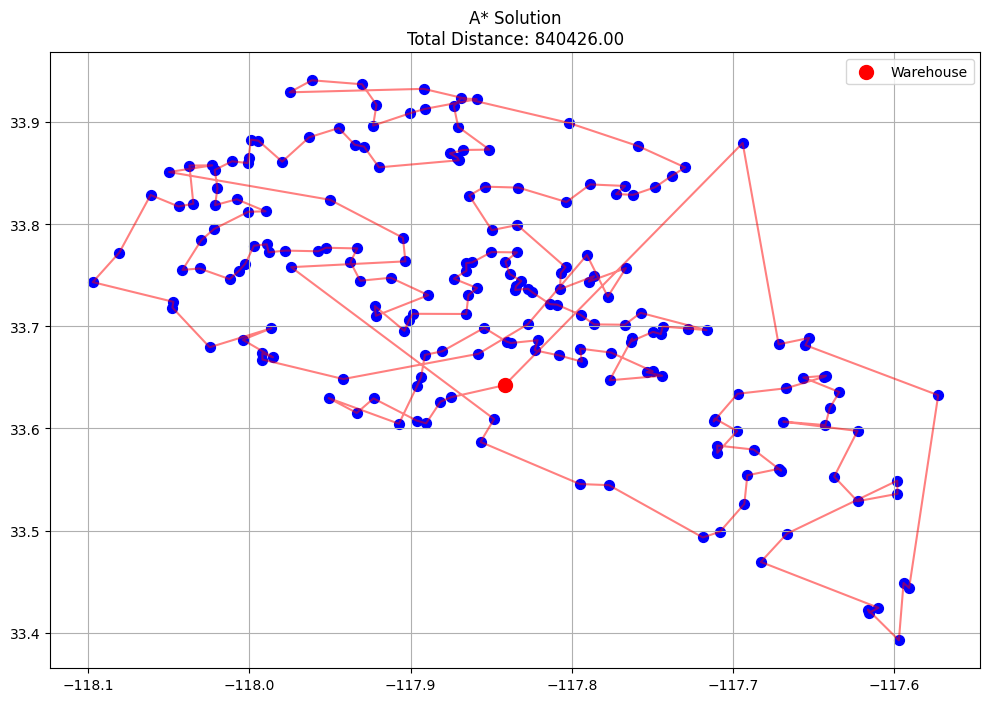

In [105]:
# Try to load cached data first
geodesic_distance_matrix, locations_mapping = load_cached_geodesic_distances()

astar_start_time = time()

aStar_path, astar_total_distance = tsp_a_star(distance_matrix, geodesic_distance_matrix)
astar_end_time = time()
astar_time = astar_end_time - astar_start_time


print("Optimal Route:", aStar_path)
print("Total Distance:", astar_total_distance, "meters")

plot_route(aStar_path, locations_mapping, distance_matrix, "A* Solution")
plotted_map(aStar_path)


## Random Search (Base case)

In [106]:
# Change it to 10000 later
def random_search(n_samples=10000):
    """Implement Random Search algorithm"""
    best_route = None
    best_distance = float('inf')  # Initialize with infinity
    
    # Get number of locations (excluding warehouse)
    n_locations = len(distance_matrix)
    
    for _ in range(n_samples):
        # Generate random route (keeping warehouse as start)
        current_route = [0] + random.sample(range(1, n_locations), n_locations-1)
        
        # Calculate total distance
        current_distance = calculate_route_distance(current_route, distance_matrix)
        
        # Update best route if current route is better
        # Take the average?
        if current_distance < best_distance:
            best_distance = current_distance
            best_route = current_route
    
    return best_route




Random Search Results:
Time taken: {end_time - start_time:.2f} seconds
Route length: 201
Total distance: 5131071.00


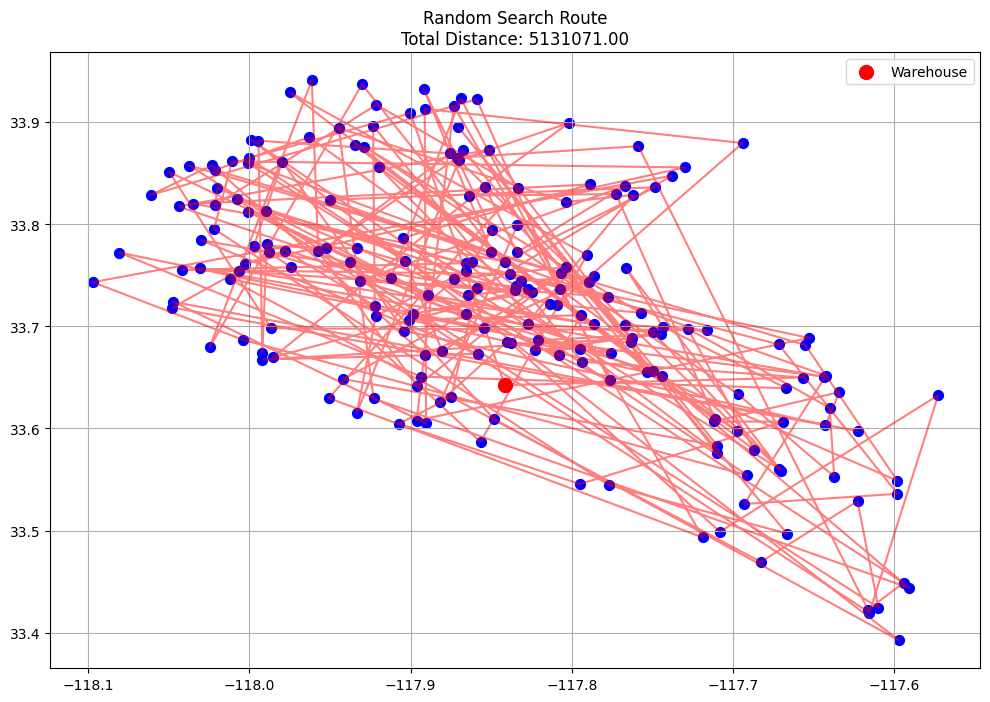

In [118]:
# Test Random Search

start_time = time()
random_route = random_search()
end_time = time()
random_time = "{end_time - start_time:.2f}"
random_distance = calculate_route_distance(random_route, distance_matrix)

print("\nRandom Search Results:")
print("Time taken: " + random_time + " seconds")
print(f"Route length: {len(random_route)}")
print(f"Total distance: {random_distance:.2f}")

plot_route(random_route, locations_mapping, distance_matrix, "Random Search Route")
plotted_map(random_route)


# Call and Draw solution google map



OR-Tools solution loaded from: 2024-11-26 00:04:06


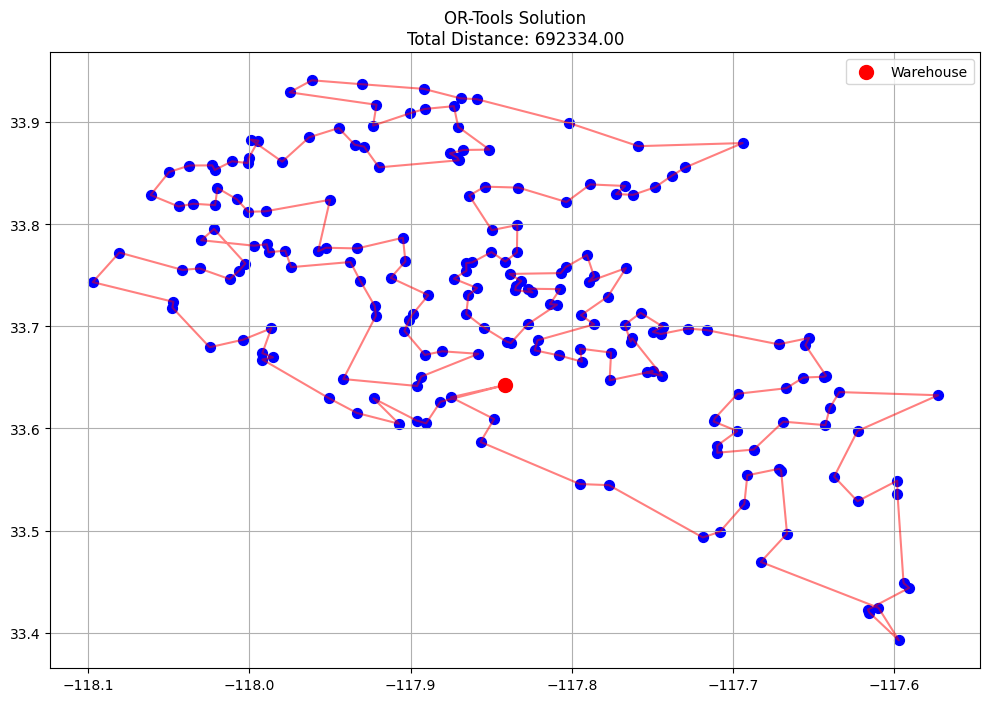

In [108]:
# Load OR-Tools solution
with open('ortools_solution.json', 'r') as f:
    ortools_data = json.load(f)
print("\nOR-Tools solution loaded from:", ortools_data['timestamp'])

# Plot OR-Tools solution
ortools_route = ortools_data['route']
ortools_distance = calculate_route_distance(ortools_route, distance_matrix)
plot_route(ortools_route, locations_mapping, distance_matrix, "OR-Tools Solution")
plotted_map(ortools_route)


In [109]:

# Create comparison table
results = [
    {
        'Algorithm': 'Nearest Neighbor',
        'Distance (km)': nn_distance/1000,
        'Time (s)': nn_time,
        'Gap to OR-Tools (%)': ((nn_distance - ortools_distance)/ortools_distance * 100)
    },
    {
        'Algorithm': 'Simulated Annealing',
        'Distance (km)': sa_distance/1000,
        'Time (s)': sa_time,
        'Gap to OR-Tools (%)': ((sa_distance - ortools_distance)/ortools_distance * 100)
    },
    {
        'Algorithm': 'A* Search',
        'Distance (km)': astar_total_distance/1000,
        'Time (s)': astar_time,
        'Gap to OR-Tools (%)': ((astar_total_distance - ortools_distance)/ortools_distance * 100)
    },
    {
        'Algorithm': 'Random Search',
        'Distance (km)': random_distance/1000,
        'Time (s)': random_time,
        'Gap to OR-Tools (%)': ((random_distance - ortools_distance)/ortools_distance * 100)
    },
    {
        'Algorithm': 'OR-Tools',
        'Distance (km)': ortools_distance/1000,
        'Time (s)': ortools_data.get('timestamp'),
        'Gap to OR-Tools (%)': 0.0
    }
]



In [110]:
results

[{'Algorithm': 'Nearest Neighbor',
  'Distance (km)': 952.123,
  'Time (s)': 0.12394094467163086,
  'Gap to OR-Tools (%)': 37.52365187900637},
 {'Algorithm': 'Simulated Annealing',
  'Distance (km)': 1602.263,
  'Time (s)': 4.840662002563477,
  'Gap to OR-Tools (%)': 131.42919457949486},
 {'Algorithm': 'A* Search',
  'Distance (km)': 834.451,
  'Time (s)': 27.51233410835266,
  'Gap to OR-Tools (%)': 20.52723107633021},
 {'Algorithm': 'Random Search',
  'Distance (km)': 5080.962,
  'Time (s)': '{end_time - start_time:.2f}',
  'Gap to OR-Tools (%)': 633.8888455572022},
 {'Algorithm': 'OR-Tools',
  'Distance (km)': 692.334,
  'Time (s)': '2024-11-26 00:04:06',
  'Gap to OR-Tools (%)': 0.0}]